In [1]:
import csv
from unidecode import unidecode
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

# Librairie pour stocker les différents modèles 
import joblib

# Traitement des stop words
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS

# Librairie pour effectuer le Word2Vec
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

# Fonction pour effectuer le graphique avec l'algorithme TSNE
from sklearn.manifold import TSNE
# Fonction pour espacer les mots sur le graphique
from adjustText import adjust_text

# Analyse de sentiment
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

/Users/romain/Documents/Python/DU_Data_Analytics/Intro Text Mining/Twitter_project/twitter_venv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/romain/Documents/Python/DU_Data_Analytics/Intro Text Mining/Twitter_project/twitter_venv/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


A travers ce nouveau notebook, nous nous concentrons sur la création de modèles permettant d'extraire divers informations contenues dans nos données :
- Dans un premier temps, on tentera de visualiser les sujets evoqués dans nos données à travers des modèles de 'Topic Modeling' comme le LDA (Latent Dirichlet Allocation) ou le NMF (Non-Negative Matrix Factorization).
- Puis ensuite on utilisera la méthode de Word Embeddings et plus précisément l'algorithme Word2Vec pour visualiser les mots utilisés dans nos tweets et essayer de voir les tendances qui peuvent se dégager.
- Puis nous présenterons succintement une méthode pour établir les sentiments de chacun de nos tweets.

In [2]:
# Importation des données
tweets = pd.read_csv('../Data_clean/tweets_fr_clean.csv').dropna(subset=['tweet_clean'])
# Transformation de la colonne 'date' au format adéquat
tweets['date'] = pd.to_datetime(tweets['date'], infer_datetime_format=True)
# Défini l'indice avec la colonne 'date'
tweets.set_index(tweets['date'], inplace = True)

tweets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37146 entries, 2021-04-21 to 2021-04-18
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            37146 non-null  datetime64[ns]
 1   time            37146 non-null  object        
 2   tweet           37146 non-null  object        
 3   tweet_clean     37146 non-null  object        
 4   hashtags        37146 non-null  object        
 5   likes_count     37146 non-null  int64         
 6   retweets_count  37146 non-null  int64         
 7   day             37146 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 2.6+ MB


- Création d'un train set et d'un test set. On conserve X_hold (le test set) dans un fichier csv.
Celui-ci nous servira essentiellement pour l'application Streamlit, afin de générer aléatoirement un tweet, et observer si les topics que le modèle trouve pour ce tweet nous semble correct

In [3]:
X_train, X_hold = train_test_split(tweets, test_size=0.05, random_state=111)

X_hold.to_csv('../Streamlit_App/generate_random_tweets.csv')

In [4]:
def display_topics(model, feature_names, no_top_words):
    """
    Fonction utilisée pour représenter les topics et les mots dans un tableau pandas.
    """
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [5]:
def plot_top_words(model, feature_names, n_top_words, title):
    """
    Arguments : un modèle (LDA ou NMF), les mots associés au modèle, un nombre maximal de mots à afficher
                et un titre pour le graphique
    
    Fonction permettant d'afficher les mots correspondants à chaque topic, ainsi que le poids qui 
    leur est associé. Comme les modèles vont de 2 à 10 topics, il est nécessaire de distinguer le cas
    ou nous avons plus de cinq topics (donc deux lignes) et le cas ou nous avons 5 topics ou moins
    pour alors n'afficher les graphiques que sur une seule ligne.
    
    Le code de cette fonction est principalement issu de la documentation de Scikit-Learn :
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    # Case when more than 5 topics
    if len(model.components_) > 5:
        fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
    
            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7, color='#3e6096')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
        
            fig.suptitle(title, fontsize=40)
    # Case when less or equal to 5 topics
    else:
        fig, axes = plt.subplots(1, len(model.components_), figsize=(15, 7), sharex=True)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
    
            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7, color='#3e6096')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 13})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
        
            fig.suptitle(title, fontsize=20)
    

    plt.subplots_adjust(top=0.88, bottom=0.05, wspace=0.90, hspace=0.3)

    return fig

#### LDA

Nous allons dans un premier temps implémenter le modèle LDA (Latent Dirichlet Allocation). Celui-ci est un modèle de 'topic modeling'. Avec ce modèle, il nous est possible à partir de nos tweets d'essayer de visualiser les différents sujets principaux évoqués dans nos tweets.

On peut considérer que ce modèle suppose que :
- chaque document peut être décrit par une distribution de topics
- chaque topic peut être décrit par une distribution de mots

Nous avons besoin d'un corpus de documents (ici de tweets) sous forme de 'bag of words', c'est à dire sous une forme matricielle qui prend en compte le nombre d'occurences de chaque mot sans tenir compte de l'ordre des mots, ainsi qu'un nombre de topic *k*.

Pour déterminer le bon nombre de topic, il est possible de recourir à deux statistiques :
- Score : une valeur de vraissemblance (log likelihood) qui mesure la qualité du modèle à coller aux données. On souhaite obtenir la valeur la plus grande.
- Perplexity : une mesure statistique qui nous informe sur la capacité à prédire un échantillon. Plus faible est le score, le meilleur est le modèle.

Ces deux statistiques n'ont pas de sens en elles mêmes, mais on peut comparer chaque valeur pour un *k* différent et voir quelle valeur *k* semble être la plus adaptée à notre situation.

In [6]:
def LDA_many_topics(nrange = (1,1)):
    """
    Argument : Choix entre unigram (1,1) ou bigram (2,2)
    
    Réalise le LDA modèle avec un nombre de topics allant de 2 à 10,
    avec la possibilité de choisir unigram ou bigram,
    puis les modèles sont stockés, ainsi que les statistiques associées à chaque modèle.
    """
    # L'objet vectorizer va servir à transformer le texte sous une forme vectorielle 
    # Max_df : pour supprimer les mots qui apparaissent dans plus de 90% des tweets car trop commun
    # Min_df : pour supprimer les mots qui apparaissent dans moins de 25 tweets car signal pas assez fort
    vectorizer = CountVectorizer(max_df=0.9, min_df=2, 
                                 ngram_range=nrange, token_pattern='\w+|\$[\d\.]+|\S+')
    
    # Applique la transformation sur les tweets nettoyés
    tf = vectorizer.fit_transform(X_train['tweet_clean']).toarray()
    
    # Conservation de l'ensemble des mots présent dans notre échantillon
    tf_feature_names = vectorizer.get_feature_names()
    print("... tf_feature_names") 
    
    # Différencie le cas ou on étudie les bigrams ou les unigrams
    if nrange == (2,2):
        # On conserve le vectorizer afin de vectoriser le test set dans l'application streamlit
        joblib.dump(vectorizer, '../models/BigramLDA_vectorizer')
        
        # On sauvegarde les differents mots, commun à tous les modèles
        with open('../models/bigram_tf_feature_names', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(tf_feature_names)
            f.close()
    else:
        # On conserve le vectorizer afin de vectoriser le test set dans l'application streamlit
        joblib.dump(vectorizer, '../models/LDA_vectorizer')
        
        # On sauvegarde les differents mots, commun à tous les modèles
        with open('../models/tf_feature_names', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(tf_feature_names)
            f.close()

            
    # Création d'un header pour le dataframe qui servira à stocker les statistiques
    # associées à chaque modèles 
    my_columns = ['Topics', 'Score', 'Perplexity']
    model_stats = pd.DataFrame(columns = my_columns)
         
    # Réalise le LDA modèle avec un nombre de topics allant de 2 à 10, puis on stocke les modèles 
    for n_topics in range(2,11,1):
        
        model = LatentDirichletAllocation(n_components = n_topics, random_state = 0)
        model.fit(tf)
        
        # Stock les statistiques de chaque modèle
        model_stats = model_stats.append(
        pd.Series(
            [
                model.n_components,
                model.score(tf),
                model.perplexity(tf)
            ],
                 index = my_columns),
                 ignore_index=True
        )

        
        # Vérifie si on considère le cas de bigrams ou unigrams et ajuste le nom du modèle
        if nrange == (2,2):
            # On conserve le modèle
            joblib.dump(model, f'../models/bigramLDA_{n_topics}_topics')
            print(f"... bigramLDA_{n_topics}_topics")
        else:
            # On conserve le modèle
            joblib.dump(model, f'../models/LDA_{n_topics}_topics')
            print(f"... LDA_{n_topics}_topics")
            
    
    # Vérifie si on considère le cas de bigrams ou unigrams et conserve le score du modèle
    if nrange == (2,2):
        model_stats.to_csv('../models/bigramLDA_scores', index=False, header=True)
    else:
        model_stats.to_csv('../models/LDA_scores', index=False, header=True)

In [7]:
%%time 

# Utilise la fonction pour créer nos modèles LDA, avec unigram d'abord, puis avec bigram
LDA_many_topics()
print('...')
LDA_many_topics(nrange = (2,2))

... tf_feature_names
... LDA_2_topics
... LDA_3_topics
... LDA_4_topics
... LDA_5_topics
... LDA_6_topics
... LDA_7_topics
... LDA_8_topics
... LDA_9_topics
... LDA_10_topics
...
... tf_feature_names
... bigramLDA_2_topics
... bigramLDA_3_topics
... bigramLDA_4_topics
... bigramLDA_5_topics
... bigramLDA_6_topics
... bigramLDA_7_topics
... bigramLDA_8_topics
... bigramLDA_9_topics
... bigramLDA_10_topics
CPU times: user 21min 47s, sys: 7min 19s, total: 29min 7s
Wall time: 1h 20min 15s


In [8]:
pd.read_csv('../models/LDA_scores')

,Topics,Score,Perplexity
0,2.0,-2.146811e+06,1743.796570
1,3.0,-2.155224e+06,1795.551556
2,4.0,-2.159646e+06,1823.373905
3,5.0,-2.165225e+06,1859.084135
4,6.0,-2.164688e+06,1855.618454
5,7.0,-2.170323e+06,1892.329284
6,8.0,-2.174215e+06,1918.106331
7,9.0,-2.178247e+06,1945.189596
8,10.0,-2.181233e+06,1965.487770


In [9]:
pd.read_csv('../models/bigramLDA_scores')

,Topics,Score,Perplexity
0,2.0,-1.240616e+06,19501.027685
1,3.0,-1.252844e+06,21495.286522
2,4.0,-1.263588e+06,23415.131443
3,5.0,-1.270431e+06,24726.322960
4,6.0,-1.275530e+06,25750.893517
5,7.0,-1.278376e+06,26341.091075
6,8.0,-1.283729e+06,27488.075891
7,9.0,-1.285819e+06,27949.173467
8,10.0,-1.288451e+06,28541.227365


On peut observer le score et la statistique de "perplexité" pour comparer les différents modèles.

Pour le cas du modèle LDA unigram, le score est maximum pour deux topics et la 'perplexity' est minimale pour deux topics ce qui suggère d'utiliser deux topics. Néanmoins, nous utiliserons généralement trois topics, afin d'avoir une meilleure idée des mots et sujets qui sont utilisé dans nos tweets.

In [10]:
# Importation de la liste du vocabulaire de notre corpus
with open('../models/tf_feature_names', 'r') as file:
    tf_feature_names_lda = list(csv.reader(file))

# Importation du modèle NMF K-L avec 10 topics
lda3 = joblib.load('../models/LDA_3_topics')

# Affichage des mots correspondants à chaque topic, ainsi que du poids associé à chaque mot pour le topic
display_topics(lda3, tf_feature_names_lda[0], 10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,clubs_non_signataires,3027.0,clubs_signataires,7431.3,florentino_perez,4155.9
1,contre,1473.1,uefa,2065.6,superleagueout,1845.3
2,ldc,1366.2,league,1342.2,vouloir,1576.7
3,ligue,1127.9,superleagueout,1323.5,pouvoir,1434.0
4,champion,986.9,joueur,1028.7,monde,1426.1
5,uefa,975.0,projet,1001.5,argent,1267.2
6,projet,745.4,president,864.9,uefa,1084.3
7,gagner,705.7,fifa,817.3,match,1071.6
8,pouvoir,702.5,supporter,798.6,joueur,1055.7
9,league,551.3,florentino_perez,758.6,league,907.4


A partir du LDA avec trois topics on peut remarquer que :
- Le topic 1 semble être surtout centré sur les clubs non signataires (PSG, Bayern Munich notamment)
- Le topic 2 concerne davantage les clubs signataires et dans une moindre mesure les slogans liés au rejet de la superleague. 
- Le topic 3 est lui centré sur la personne de Florentino Perez et donne également de l'importance aux slogans associés au rejet du projet de Superleague ("superleagueout").

Finalement, le modèle LDA semble être en mesure de bien saisir les différents topics présents dans nos tweets. Néanmoins, cette méthode est relativement lente, et il est intéressant d'essayer d'autres méthodes plus rapides et également afin de pouvoir comparer les différents résultats. 
Dès lors dans la prochaine partie nous allons adopter une autre méthode via l'algorithme NMF.

#### NMF

Source : https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

A la difference du LDA modèle où nous avons utilisé la fonction *CountVectorizer* pour compter le nombre d'occurences de chaque mot, pour le modèle non supervisé NMF nous utilisons la fonction *TfidfVectorizer* (pour frequency-inverse document frequency). Celle-ci permet de de pondérer l'importance de chaque mot dans un tweet, par son importance relative dans notre corpus de tweets.

Afin de mieux visualiser ce que fait l'algorithme NMF, nous avons réalisé ce schéma ci-dessous.

![alt text](NMF.png "Title")

A partir de la matrice Tf-Idf (matrice de gauche) de dimension M (M = nombre de tweets) par N (N = nombre de mot dans notre vocabulaire), l'algorithme NMF va décomposer celle-ci en deux nouvelles matrices.
La première sera de dimension M (nombre de tweets) par k (nombre de topics) tandis que la seconde sera de dimension k (nombre de topics) par N (nombre de mots).

Dès lors, cela nous permettra de déterminer l'appartenance de chaque tweet à un topic donné, ainsi de déterminer l'importance relative de chaque mot pour un topic donné.

Il existe plusieurs façons de calculer cette décomposition de matrice. Deux méthodes seront utilisées ici, la méthode d'optimisation de Frobenius ainsi que celle de Kullback-Leibler.

Concernant le choix du nombre de topic, il semble qu'il existe une statistique qui s'appelle "coherence score". Cependant celle-ci n'existe pas dans la librairie Scikit-Learn, et nous n'avons pas pu trouver comment l'implanter. Dès lors nous essaierons de déterminer le nombre de topics adéquat à partir des résultats obtenus par la méthode NMF et en comparant les résultats avec le modèle LDA.

In [11]:
# Réalise le NMF modèle avec un nombre de topics allant de 2 à 10, puis on stocke les modèles 
# 2 méthodes de NMF sont effectués: Frobenius, puis Kullback-Leibler
    
def NMF_many_topics(option):
    # L'objet  tfidf_vectorizer est utilisé pour transformer le texte sous forme vectorielle
    # Max_df : pour supprimer les mots qui apparaissent dans plus de 90% des tweets car trop commun
    # Min_df : pour supprimer les mots qui apparaissent dans moins de 25 tweets car signal pas assez fort
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=25,
                                   max_features=2000)

    # Applique la transformation
    tf = tfidf_vectorizer.fit_transform(X_train['tweet_clean'])
    
    # Conservation de l'ensemble des mots présent dans notre échantillon
    tf_feature_names = tfidf_vectorizer.get_feature_names()
    print(f"... tf_feature_names_nmf")
    # On sauvegarde les differents mots, commun à tous les modèles
    with open('../models/tf_feature_names_nmf', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(tf_feature_names)
        f.close()
    
    # On conserve le vectorizer afin de vectoriser le test set dans l'application streamlit
        joblib.dump(tfidf_vectorizer, '../models/NMF_vectorizer')
        
    # Réalise le NMF modèle avec un nombre de topics allant de 2 à 10, puis on stocke les modèles 
    # 2 méthodes de NMF sont effectués: Frobenius, puis Kullback-Leibler
    if option == 'frobenius':
        for n_topics in range(2,11,1):
            model = NMF(n_components = n_topics, random_state = 0, alpha=.1, l1_ratio=.5)
            model.fit(tf)
            joblib.dump(model, f'../models/NMF_Frobenius_{n_topics}_topics')
            print(f"... NMF_Frobenius_{n_topics}_topics")
    else:
        for n_topics in range(2,11,1):
            model = NMF(n_components= n_topics, random_state=0,
                        beta_loss='kullback-leibler', solver='mu', 
                        max_iter=1000, alpha=.1, l1_ratio=.5)
            model.fit(tf)
            joblib.dump(model, f'../models/NMF_K-L_{n_topics}_topics')
            print(f"... NMF_K-L_{n_topics}_topics")

In [12]:
%%time 

NMF_many_topics(option = 'frobenius')
NMF_many_topics(option = 'K-L')

... tf_feature_names_nmf
... NMF_Frobenius_2_topics
... NMF_Frobenius_3_topics
... NMF_Frobenius_4_topics
... NMF_Frobenius_5_topics
... NMF_Frobenius_6_topics
... NMF_Frobenius_7_topics
... NMF_Frobenius_8_topics
... NMF_Frobenius_9_topics
... NMF_Frobenius_10_topics
... tf_feature_names_nmf
... NMF_K-L_2_topics
... NMF_K-L_3_topics
... NMF_K-L_4_topics
... NMF_K-L_5_topics
... NMF_K-L_6_topics
... NMF_K-L_7_topics
... NMF_K-L_8_topics
... NMF_K-L_9_topics
... NMF_K-L_10_topics
CPU times: user 51.6 s, sys: 1min 23s, total: 2min 15s
Wall time: 34.3 s


- On peut immédiatement remarqué que le temps de calcul pour cet algorithme est sensiblement plus rapide que pour le modèle LDA. Celui-ci est passé d'une vingtaine de minute approximativement à un peu plus de deux minutes.

In [13]:
# Importation de la liste du vocabulaire de notre corpus
with open('../models/tf_feature_names_nmf', 'r') as file:
    tf_feature_names_nmf = list(csv.reader(file))

# Importation du modèle NMF K-L avec 10 topics
nmf3 = joblib.load('../models/NMF_K-L_3_topics')

# Affichage des mots correspondants à chaque topic, ainsi que du poids associé à chaque mot pour le topic
display_topics(nmf3, tf_feature_names_nmf[0], 10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,clubs_signataires,2.7,florentino_perez,2.8,clubs_non_signataires,0.9
1,projet,0.8,superleagueout,1.6,uefa,0.8
2,league,0.6,mourir,0.5,joueur,0.7
3,fin,0.4,moment,0.5,ldc,0.7
4,fan,0.4,uefa,0.4,ligue,0.7
5,superleagueout,0.4,coup,0.4,contre,0.6
6,rejoindre,0.4,passer,0.4,pouvoir,0.6
7,supporter,0.4,soir,0.4,champion,0.6
8,fondateur,0.4,president,0.4,fifa,0.6
9,annoncer,0.4,tuer,0.4,monde,0.5


On peut observer que les résultats sont ici légèrement différents de ceux obtenus avec la méthode LDA :
   - Le topic 1 est associé aux clubs signataires
   - Le topic 2 est associé à Florentino Perez et aux slogans contre la Superleague, suggèrant que le rejet du projet est associé à sa personne.
   - Le topic 3 est lui associé aux clubs non signataires.

On peut également représenter nos données sous forme de graphiques afin de mieux visualiser les différents topics.

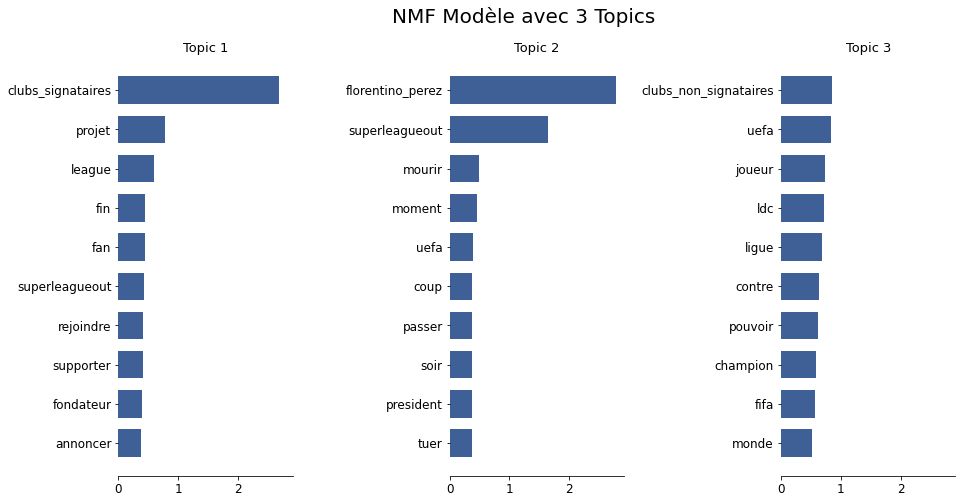

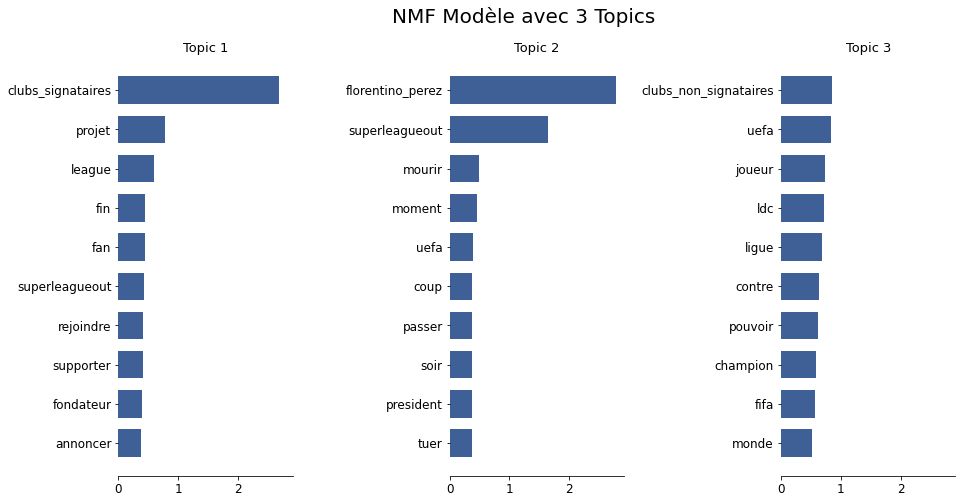

In [14]:
plot_top_words(nmf3, tf_feature_names_nmf[0], 10, "NMF Modèle avec 3 Topics")

Un des problèmes des approches retenues précédemment est l'absence de contextualisation. Dans la partie suivante nous allons tenter de remédier à cela.

### Gensim

Ici, nous utilisons une nouvelle librairie (*Gensim*) pour y effectuer une réprésentation vectorielle de notre corpus de documents via l'utilisation de l'algorithme Word2Vec. Avec cette nouvelle représentation de nos données textuelles, le sens d'un mot est finalement un point dans un espace vectoriel basé sur la distribution de chaque mot. Ainsi, cela nous permet de  représenter des mots ayant un sens similaire dans un espace vectoriel proche. Des mots ayant un sens proche seront donc également proche dans l'espace généré par les vecteurs (ici 100).

Finalement, avec l'algorithme Word2Vec, plutot que de compter le nombre d'occurences de chaque mot à proximité d'un autre, on cherche à prédire si un mot a une plus ou moins forte probabilité de se trouver à proximité d'un autre mot.

La représentation par le Tf-Idf est aussi un 'embedding', une représentation sous forme matricielle, mais les mots sont représentés sous forme de sparse matrix (matrice creuse de la taille du vocabulaire de nos documents), c'est à dire qui contient majoritairement des 0.
Word2Vec au contraire est une réprésentation 'dense' de la matrice, il y a peu de 0.

La représentation sous forme de 'Dense Matrix' permet de réduire la dimension dans laquelle notre modèle doit trouver les valeurs associées à chaque paramétres. Cela est important et permet d'améliorer la capacité du modèle à se généraliser. En effet, cette réprésentation permet de mieux capturer la similarité entre des mots, et notamment par exemple avec des mots qui sont synonymes.

Néanmoins, comme cet algorithme permet de représenter nos données sous la forme d'une matrice avec 100 colonnes, il est nécessaire d'utiliser un algorithme de réduction de dimensions.

L'algorithme TSNE sera ici utilisé. Cela nous permettra en effet de réduire notre nombre de dimension de 100 à 2, et ainsi de pouvoir visualiser la proximité ou non des mots entre eux.

#### Word2Vec

Ici nous effectuons un nouveau cleaning de nos données pour mieux adapter les stop words choisis afin de faciliter la visualisation.

In [16]:
%%time 

tweets_w2vec = tweets.copy()

nlp = spacy.load("fr_core_news_md") 

add_stop_words = ['étaient', 'étais', 'était', 'étant', 'été', 'être', 'etre', 'etes', 'faire', 'aller', 'voir',
                  'rt', 'mettre', 'prendre', "coup", 'soir', 'hier', 'matin', 'oui', 'non', 'ici', 'aucun', 'revenir', 
                  'sur', 'cas', 'moyen', 'lieu', 'part', 'tete', 'cause', 'genre', 'peut', 'etre', 'jour', 'nom',
                  'grace', 'loin', 'cote', 'debut', 'finir','penser', 'video', 'the', 'actuellement', 'arrive', 
                  'donne', 'entrain', 'trop', 'chose', 'année', 'fc', 'ca', 'retrouver', 'connaitre', 'vivre',
                  'tour', 'suite', 'svp', 'mec'
                  'aujourd', 'hui', 'gt', 'venir','ô',  'à', 'â', 'ça', 'ès','a', 'b','c', 'd', 'e', 'f', 'g', 'h', 
                  'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'qu']

for word in add_stop_words:
    STOP_WORDS.add(word)
    
def tweet_cleaner(pandasSeries):
    """
    Fonction ayant pour but de nettoyer nos tweets.
    Prend comme paramètre une pandas series.
    Opérations effectuées : mise au format string, minuscule, suppression des #, des mentions de compte,
    des URL, puis lemmatisation de nos données via Spacy, et suppression des stop words. Ensuite,
    traitement des données afin d'identifier les différents alias utilisés pour parler de clubs ou de personnalités.
    """
    
    print("#### Nettoyage en cours ####") 
    
    # Confirmation que chaque article est bien de type str
    pandasSeries = pandasSeries.apply(lambda x : str(x))
    
    # Passage en minuscule
    print("... Passage en minuscule") 
    pandasSeries = pandasSeries.apply(lambda x : x.lower())

    # Suppression des #
    print("... Suppression des #") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"#", '', x))
    
    # Suppression des noms de compte #
    print("... Suppression des @account") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"@\S+", '', x))
    
    # Suppression des url #
    print("... Suppression des url") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"http\S+", '', x))
    
    # Lemmatisation
    print("... Lemmatisation and Suppression des Stop words")
    
    pandasSeries = pd.Series((nlp.pipe(pandasSeries)))
    
    tweets_clean = []
    for tweet in pandasSeries:
        tokens_clean = []
        for token in tweet:
            if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS):
                tokens_clean.append((unidecode(token.lemma_)))
        tweets_clean.append(' '.join(tokens_clean))
    
    pandasSeries = pd.Series(tweets_clean)
    
    ## Suppression des caractères spéciaux et numériques
    print("... Suppression des caractères spéciaux et numériques") 
    #pandasSeries = pandasSeries.apply(lambda x :re.sub(r"[^a-z]+", ' ', x))
    
    print("#### Nettoyage OK! ####")

    return pandasSeries


tweets_w2vec = tweet_cleaner(tweets_w2vec.tweet)
tweets_w2vec

#### Nettoyage en cours ####
... Passage en minuscule
... Suppression des #
... Suppression des @account
... Suppression des url
... Lemmatisation and Suppression des Stop words
... Suppression des caractères spéciaux et numériques
#### Nettoyage OK! ####
CPU times: user 1min 50s, sys: 4.15 s, total: 1min 54s
Wall time: 1min 59s


0        jean michel incisif face 12 frondeur superleag...
1        beppe marotta ( ad inter ) lancer cri alarme :...
2        echec projet superleague , mort football visag...
3         jean michel heureux mort superleague    teamom  
4        3 - 1 juve contre parme ( 2 coupe uefa ) compr...
                               ...                        
37141      comprendre accepter vouloir tuer football . ...
37142     dingue ! groupe supporter chelsea ( cst ) rea...
37143    superleague clairement projet nefaste foot . r...
37144      superleague  bravo club francais allemand re...
37145                        mascarade superleague    , ? 
Length: 37146, dtype: object

In [17]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=False, min_len=3, max_len=35)
        final.append(new)
    return (final)

data_words = gen_words(tweets_w2vec)

model = Word2Vec(sentences=data_words, vector_size=100, min_count=150)
model.save("../models/word2vec.model")

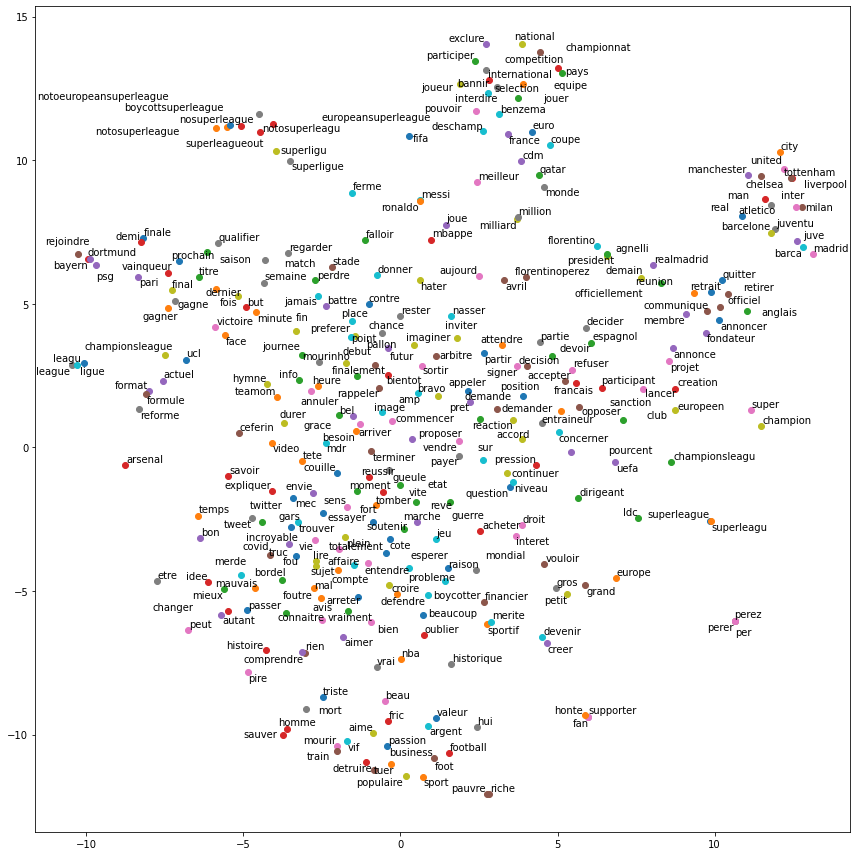

CPU times: user 1min 32s, sys: 4.19 s, total: 1min 36s
Wall time: 1min 24s


In [18]:
%%time 
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv.word_vec(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(12, 12),tight_layout=True) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
    texts = []
    for X, Y, s in zip(x, y, labels):
        texts.append(plt.text(X, Y, s))
      
    adjust_text(texts)
    
    plt.savefig("../Streamlit_App/graphs/word2vec_TSNE.jpg", bbox_inches='tight', dpi = 300)
    plt.show()
    

tsne_plot(model)

Plusieurs clusters peuvent être identifier à partir de ce graphique:
- En haut à droite, tous les clubs signataires sont parfaitement identifiés. On voit également que les présidents et vice-président du projet (Florentino Perez et Andrea Agnelli) sont proches de ce cluster, comme les mots "communiqué", "fondateur", "officiel".
- En haut à gauche, les slogans associés au rejet de la superleague sont également correctement identifiés.
- Légèrement en dessous, les clubs non signataires (PSG, Bayern, Dortmund notamment) sont bien présents.
- Tout en haut, un cluster concernant l'équipe de France est présent.
- Tout en bas, on peut retrouver les termes associés au rejet du projet et de la critique de l'argent dans le foot avec des termes comme "fric", "business", "détruire", "populaire", "pauvre", "riche", "tuer", "mourir".

Cette méthode semble donner des résultats très encourageants du fait de sa capacité à identifier les similarités entre les différents mots présent dans notre échantillon.

In [19]:
pd.DataFrame(model.wv.most_similar('superleagueout', topn=10), columns = ['Mots', 'Similarity'])

,Mots,Similarity
0,notosuperleagu,0.915392
1,notoeuropeansuperleague,0.909179
2,europeansuperleague,0.889609
3,superligu,0.879070
4,boycottsuperleague,0.853129
5,nosuperleague,0.829739
6,championsleagu,0.818854
7,florentinoperez,0.817178
8,teamom,0.736554
9,notosuperleague,0.734727


## Sentiment Analysis

Dans cette dernière sous partie, nous effectuons une analyse de sentiment simple, afin d'évaluer si notre algorithme est à même de mesurer de façon adéquate chacun de nos tweets.
Pour cela, nous utilisons la librairie *vaderSentiment_fr*.
Dans un premier temps, nous calculons le score "polarity". Chaque valeur est comprise entre -1 et 1. Nous considérerons un tweet comme négatif si le score de polarité est négatif, neutre si le score est égale à 0 et positif lorsque le score est plus grand que 0.

In [20]:
SIA = SentimentIntensityAnalyzer()

In [21]:
pd.set_option('max_colwidth', 140)

In [22]:
polarity = []
for tweet in tweets['tweet_clean']:
    polarity.append(SIA.polarity_scores(tweet)['compound'])

In [23]:
tweets['polarity'] = polarity

tweets = tweets[['tweet', 'tweet_clean', 'polarity']]
tweets.sort_values(by = 'polarity')

,tweet,tweet_clean,polarity
date,,,
2021-04-19,Honte à toi Perez Honte à toi Agnelli Honte à toi Glazer Honte à toi Al Mubarak Honte à toi Laporta Honte à toi Abramovitch Honte à t...,honte florentino_perez hont andrea_agnelli honte glazer honte al mubarak honte laporta hont abramovitch honte werner honte cerezo honte ...,-0.9834
2021-04-19,Anti UEFA X Anti Superleague Des voleurs qui se vole et qui rentre en guerre ! Au cul toute c'est grosse merde qui gâche le football. ...,anti uefa anti voleur vole rentre guerre cul gros merde gache voleur superleagueout fuckuefer,-0.9769
2021-04-20,De quoi tu parles le vieux ? Arsenal : A chier Athlético : à chier Tottenham : a chier Juve : a chier AC milan : a chier Man U : a ...,vieux clubs_signataires chier athletico chier clubs_signataires chier clubs_signataires chier clubs_signataires chier man chier,-0.9705
2021-04-19,#SuperLeague Bras de fer d'enculés. D'un côté les enculés de l'UEFA De l'autre les enculés des 12 grands clubs. Le foot est détenu pa...,bras fer encule cote encule uefa encule grand detenir encule rien soleil,-0.9629
2021-04-18,425 millions en cas d’acceptation à intégrer la #SuperLeague Réal Madrid =&gt; PUTE Barcelone =&gt; PUTE Atletico Madrid =&gt; PUTE Int...,million cas acceptation integrer clubs_signataires clubs_signataires gt pute barcelon gt pute clubs_signataires clubs_signataires gt put...,-0.9595
...,...,...,...
2021-04-19,Mdrr après on fait un All-star games les 11 meilleurs joueurs de la SuperLeaugue contre les 11 meilleurs joueurs de la Ligue des Champio...,mdrr all star games meilleur joueur superleaugue contre meilleur joueur ligue champion,0.9719
2021-04-21,"Le football éthique est un mensonge. Le meilleur spectacle du monde est construit à un prix élevé. Le football riche, réputé et endetté ...",ethique mensonge meilleur spectacle monde construire prix eleve riche repute endetter besoin evolution ethique respecter uefa fifa gouve...,0.9738
2021-04-19,@jeromelatta La #SuperLeague est la seule solution pour répondre aux déséquilibres structurels des championnats nationaux. Réunir les 50...,solution repondre desequilibre structurel championnat national reunir meilleur joueur monde meilleur equipe europe jouer dansle meilleur...,0.9741


In [24]:
def Sentiments(score):
    if score < 0:
        return 'negatif'
    elif score == 0:
        return 'neutre'
    else:
        return 'positif'
 
    
tweets['sentiment'] = tweets['polarity'].apply(Sentiments)
tweets

,tweet,tweet_clean,polarity,sentiment
date,,,,
2021-04-21,Jean Michel incisif face aux 12 frondeurs de la #SuperLeague @EtienneLantier2 @MalikaKwiatko13 #teamOm ça sera jamais plus comme avant.....,jean michel incisif face frondeur teamom jamais,0.0000,neutre
2021-04-21,Beppe #Marotta (AD Inter) lance un cri d’alarme : “Faire des excuses pour la #SuperLeague ? La bonté de cette action vient du fait que l...,beppe marotta ad clubs_signataires lancer cri alarme excuse bonte action venir proprietaire vouloir bien risque faillite intervention in...,-0.7351,negatif
2021-04-21,"Avec l'échec du projet de #SuperLeague, la mort du football a un nouveau visage. #OLASM https://t.co/Y2pgfs0F1m",echec projet mort visage olasm,-0.5719,negatif
2021-04-21,Jean Michel trop heureux de la mort de la #SuperLeague @EtienneLantier2 @MalikaKwiatko13 #teamOm https://t.co/qqAcT3rLr4,jean michel trop heureux mort teamom,0.4243,positif
2021-04-21,3-1 pour la Juve contre Parme (2 Coupes UEFA) et les gens ne comprennent toujours pas qu'on a besoin de #SuperLeague ?,clubs_signataires contre parme coupe uefa comprendre besoin,-0.2960,negatif
...,...,...,...,...
2021-04-18,@Arsenal_FRA Je ne comprends même pas comment on peut accepter de vouloir tuer le football. L’UEFA c’est déjà pas folichon alors cette ...,comprendre pouvoir accepter vouloir tuer uefa folichon carrement execution,-0.4215,negatif
2021-04-18,🔴 Dingue ! Des groupes de supporters de Chelsea (CST) ont déjà réagi en critiquant le projet de Superligue alors que les Blues veulent l...,dingue groupe supporter clubs_signataires cst reagir critiquer projet superligue blues vouloir rejoindre instance supporter defoncer pro...,0.3400,positif
2021-04-18,La #SuperLeague est clairement un projet néfaste pour le foot. Mais la réforme de l' #UCL qui se profile ne va pas nous offrir une compé...,clairement projet nefaste reforme ucl profile offrir competition respectueux histoire supporter boutique defendre meilleur machine fric ...,0.9118,positif


In [25]:
tweets['sentiment'].value_counts()

positif    17154
negatif    10335
neutre      9657
Name: sentiment, dtype: int64

In [26]:
tweets[tweets['sentiment'] == 'positif']

,tweet,tweet_clean,polarity,sentiment
date,,,,
2021-04-21,Jean Michel trop heureux de la mort de la #SuperLeague @EtienneLantier2 @MalikaKwiatko13 #teamOm https://t.co/qqAcT3rLr4,jean michel trop heureux mort teamom,0.4243,positif
2021-04-21,Aulas salue le travail de Nasser al-Khelaifi contre la Superleague #TeamPSG #PSG #Superleague https://t.co/vImHgIHsOk https://t.co/p...,aula salue travail nasser al khelaifi contre teampsg clubs_non_signataires,0.2732,positif
2021-04-21,"Les présidents du Bayern, de l'Ajax, de Porto ont le droit de s'exprimer sur la champions league ou la super ligue. @JM_Aulas et #Nasse...",president clubs_non_signataires aja porto droit exprimer champion league ligue nasser jour party legende competition ecouter uefa,0.5994,positif
2021-04-21,"@alexandreruiz Tous les clubs #SuperLeague sont dans le dur depuis Lundi 😬 Leeds, Brighton, Sassuolo... Bravo à ces ""petits""",dur lundi leeds brighton sassuolo bravo petit,0.4588,positif
2021-04-21,"Je serais pas étonné qu'on apprenne que Vinai n'ait eu aucun rôle dans cette #SuperLeague, pourtant c'est lui qui présente ses excuses a...",etonner apprendre vinai aucun role pourtant presente excuse groupe personnel essayer reparer pot casser pl peut etre virer tandis kroenk...,0.0258,positif
...,...,...,...,...
2021-04-18,Ok ok la #SuperLeague tout ça mais ça ? https://t.co/PlyITw8WfE,ok ok,0.5267,positif
2021-04-18,@pasdemaladresse RÉÉCRITURE : Le @PSG_inside et le @FCBayern_French sont contre la #SuperLeague (d'ici la fin de la CDM 2022 pour le clu...,reecriture contre ici fin cdm parisien ici reponse positif clubs_non_signataires bavarois,0.1779,positif
2021-04-18,"Bon, 🆗 l'OM refuse de faire parti de la SuperLeague a condition que les 5 premiers de Ligue 1 soit qualifiés pour la prochaine Ligue De...",bon om refuse parti condition ligue qualifie prochain ligue champion teamom cfc eds rmcliv,0.6486,positif


In [27]:
tweets[tweets['sentiment'] == 'neutre']

,tweet,tweet_clean,polarity,sentiment
date,,,,
2021-04-21,Jean Michel incisif face aux 12 frondeurs de la #SuperLeague @EtienneLantier2 @MalikaKwiatko13 #teamOm ça sera jamais plus comme avant.....,jean michel incisif face frondeur teamom jamais,0.0,neutre
2021-04-21,48 heures pour monter un restaurant n'a rien d'insurmontable. Y en a qui ont monté et démonté une #Superleague en autant de temps #TopChef,heure monter restaurant rien insurmontable monter demonter autant temps topchef,0.0,neutre
2021-04-21,@TVASports @clubdefootmtl Que pensez-vous de la tentative de formation de la #SuperLeague ?,penser tentative formation,0.0,neutre
2021-04-21,Aubameyang marque le but du 8-1 contre le Real en #SuperLeague,aubameyang marque but contre clubs_signataires,0.0,neutre
2021-04-21,de Ligt portaci in #SuperLeague,ligt portaci in,0.0,neutre
...,...,...,...,...
2021-04-18,"#SuperLeague ou pas, #NonTiLasceremoMai 🔴⚫ @acmilan",nontilasceremomai,0.0,neutre
2021-04-18,Le PSG et le Bayern en LDC. #UEFA #SuperLeague https://t.co/T0qCO2dHRY,clubs_non_signataires clubs_non_signataires ldc uefa,0.0,neutre
2021-04-18,@ndione_ada @ndione_ada votre avis sur cette histoire de #superLeague ?,avis histoire,0.0,neutre


In [28]:
tweets[tweets['sentiment'] == 'negatif']

,tweet,tweet_clean,polarity,sentiment
date,,,,
2021-04-21,Beppe #Marotta (AD Inter) lance un cri d’alarme : “Faire des excuses pour la #SuperLeague ? La bonté de cette action vient du fait que l...,beppe marotta ad clubs_signataires lancer cri alarme excuse bonte action venir proprietaire vouloir bien risque faillite intervention in...,-0.7351,negatif
2021-04-21,"Avec l'échec du projet de #SuperLeague, la mort du football a un nouveau visage. #OLASM https://t.co/Y2pgfs0F1m",echec projet mort visage olasm,-0.5719,negatif
2021-04-21,3-1 pour la Juve contre Parme (2 Coupes UEFA) et les gens ne comprennent toujours pas qu'on a besoin de #SuperLeague ?,clubs_signataires contre parme coupe uefa comprendre besoin,-0.2960,negatif
2021-04-21,Alors l’@UEFAcom_fr vous voulez sanctionner les 12 clubs de la superleague comme si ils avaient commis un crime mais quand il s’agit de ...,vouloir sanctionner commettre crime agir raciste entendre probleme justice uefa superleagueout,-0.7579,negatif
2021-04-21,#fredhermel #SuperLeague #realmadrid #shame pathétique comme toujours ce faux cul d’hermel https://t.co/kj4tN28bPS,fredhermel clubs_signataires shame pathetique faux cul hermel,-0.8271,negatif
...,...,...,...,...
2021-04-18,"Ils ont souvent été à côté de la plaque, bravo aux clubs français d’avoir refusé la supercherie de la #SuperLeague européenne",cote plaque bravo francais refuser supercherie europeen,-0.1779,negatif
2021-04-18,L'idée de la création d'une #SuperLeague est stupide ! Mais n'oublions pas qu'il faut révolutionner le système de l'UEFA et de la FIFA c...,idee creation stupide oublier falloir revolutionner systeme uefa fifa corrompu os spectaculaire falloir garder eradiquer corruption,-0.2960,negatif
2021-04-18,"Le football que nous aimons meurt depuis déjà trop d’années. A force de business, de droits TV, de marketing, de magouilles et d’arrange...",aimer mourir trop annee force business droit tv marketing magouille arrangement uefa ucl,-0.1970,negatif
